   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Dataset length: 768
Dataset length without Glucose = 0: 763
Params: a = 0.1939, b = 0.7325

Kholmogorov-Smirnov results:
D = 0.5264
Crit value(alpha=0.05) = 0.1271
Model is false


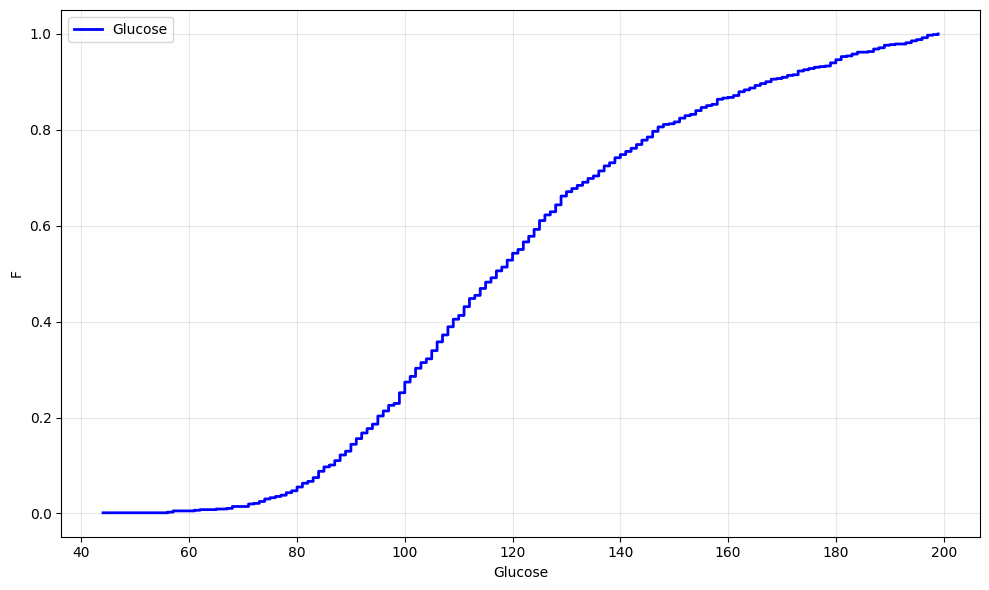

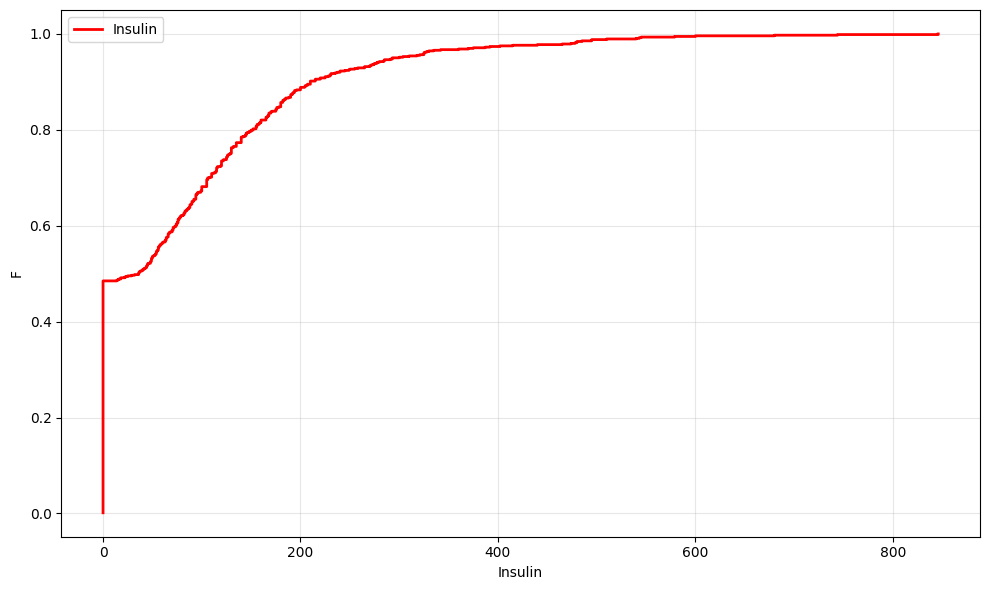

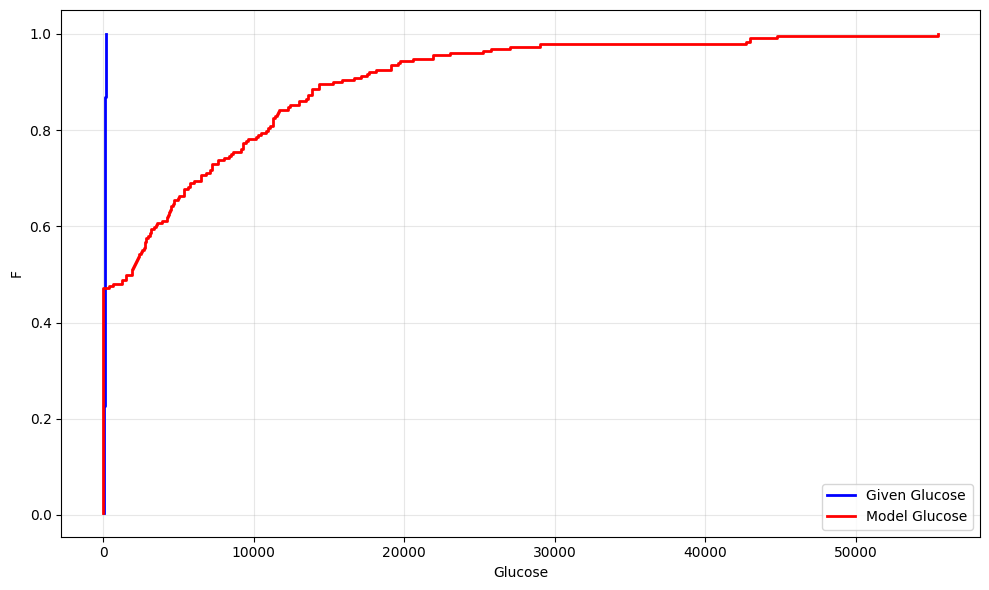

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

data = pd.read_csv('diabetes.csv')

print(data.head())
data = data[['Glucose', 'Insulin']].dropna()
print(f"Dataset length: {len(data)}")
data = data[data['Glucose'] > 0]

delta = 0.3
data['Glucose_shifted'] = data['Glucose']
data['Insulin_shifted'] = data['Insulin'] + delta

print(f"Dataset length without Glucose = 0: {len(data)}")

train, test = train_test_split(data, test_size=0.3, random_state=42)

def power_law_fit(x, y):
    logx = np.log(x)
    logy = np.log(y)
    b = np.cov(logx, logy)[0,1] / np.var(logx)
    a = np.exp(np.mean(logy) - b*np.mean(logx))
    return a, b

a, b = power_law_fit(train['Glucose_shifted'], train['Insulin_shifted'])
print(f"Params: a = {a:.4f}, b = {b:.4f}")

def ks_test(sample1, sample2):
    s1 = np.sort(sample1)
    s2 = np.sort(sample2)

    def ecdf(sample):
        x = np.sort(sample)
        y = np.arange(1, len(x) + 1) / len(x)
        return x, y

    x1, y1 = ecdf(s1)
    x2, y2 = ecdf(s2)

    all_x = np.sort(np.concatenate([x1, x2]))
    y1_interp = np.interp(all_x, x1, y1)
    y2_interp = np.interp(all_x, x2, y2)

    D = np.max(np.abs(y1_interp - y2_interp))

    n1, n2 = len(sample1), len(sample2)
    critical_value = 1.36 * math.sqrt((n1 + n2) / (n1 * n2))

    return D, critical_value

glucose_transformed = (test['Insulin_shifted'] / a) ** (1 / b)

D, critical_value = ks_test(test['Glucose_shifted'], glucose_transformed)

def plot_ecdf(sample, label, color):
    x = np.sort(sample)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.step(x, y, where='post', label=label, color=color, linewidth=2)

print("\nKholmogorov-Smirnov results:")
print(f"D = {D:.4f}")
print(f"Crit value(alpha=0.05) = {critical_value:.4f}")
if D < critical_value:
    print("Model is good")
else:
    print("Model is false")

plt.figure(figsize=(10, 6))
plot_ecdf(data['Glucose'], "Glucose", "blue")

plt.xlabel('Glucose')
plt.ylabel('F')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_ecdf(data['Insulin'], "Insulin", "red")

plt.xlabel('Insulin')
plt.ylabel('F')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plot_ecdf(test['Glucose_shifted'], "Given Glucose", "blue")
plot_ecdf(glucose_transformed, "Model Glucose", "red")

plt.xlabel('Glucose')
plt.ylabel('F')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()